In [1]:
import sys
import os
import importlib
import random

import numpy as np
import scipy
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt

In [2]:
# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
from jax import grad, vmap, jacfwd, jacrev, jit

In [3]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [4]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

# Load Data

In [5]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

In [6]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [7]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

In [8]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(4150115, 2) (4150115, 60)


In [9]:
# load committors
qp_du = np.load("../../data/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns
w = np.load(
    "../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[0]

In [10]:
rf161 = list(np.load("../../data/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load("../../data/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)

# Optimization

In [227]:
def corr_q(e, z_traj, z0, lag=500, sigma=1):
    C = 0
    for z in z_traj:
        q_0 = q(e, z[:-lag], z0, sigma=sigma)
        q_tau = q(e, z[lag:], z0, sigma=sigma)
        # C += jnp.mean(q_0 * q_tau)
        # C -= jnp.mean(q_0**2)
        C += jnp.mean((q_tau - q_0)**2)
    return C * -0.5 # want to maximize, so flip sign

def Lagrangian(x, z_traj, z0, lag=500, sigma=1):
    e = x[:-1]
    L = corr_q(e, z_traj, z0, lag=lag, sigma=sigma)
    L -= x[-1] * (jnp.linalg.norm(e) - 1)
    return L

@jit
def q(e, z, z0, sigma=1):
    """Compute the value of the committor for a trajectory z given
    a unit vector e
    
    z : ndarray of shape (n_frames, n_features)
    z0 : ndarray of shape (n_features,)
    """
    arg = jnp.dot((z - z0), e) / sigma
    return 0.5 * (1 + jax.scipy.special.erf(arg))

@jit
def q_pdiff(e, z, z0, sigma=1):
    """Compute the gradient of the committor for a trajectory
    z given a unit vector e with respect to e.
    
    Parameters
    ----------
    e : ndarray of shape (n_features,)
        Unit vector controlling direction of committor erf function
    z : ndarray of shape (n_frames, n_features)
        Array of collective variables
    z0 : float
    
    Returns
    -------
    ans : ndarray of shape (n_features,)
        Gradient of erf committor with respect to the input vector e
    """
    arg = jnp.dot((z - z0), e) / sigma
    ans = z.T * jnp.exp(-arg * arg) / (sigma * jnp.sqrt(jnp.pi))
    return ans

def dL_e(e, lmbda, z_traj, z0, lag, sigma=1):
    """Compute the derivatives of the committor correlation function Lagrangian
    with respect to the unit vector e.
    
    Parameters
    ---------- 
    e : ndarray of shape (n_features,)
        Unit vector controlling direction of committor erf function
    lmbda : float
        Lagrange multiplier
    z_traj : array-like of ndarray of shape (n_frames, n_features)
        List of trajectories of collective variables
    z0 : float
    lag : int
    
    Returns
    -------
    ans : ndarray of shape (n_features + 1,)
    """
    ans = 0
    for z in z_traj:
        n = len(z) - lag
        # first term, q(tau) * d/d e_i (q(0))
        ans += jnp.dot(q_pdiff(e, z[:-lag], z0, sigma=sigma), q(e, z[lag:], z0, sigma=sigma)) / n
        # second term
        ans += jnp.dot(q_pdiff(e, z[lag:], z0, sigma=sigma), q(e, z[:-lag], z0, sigma=sigma)) / n
        # third term
        ans -= 2 * jnp.dot(q_pdiff(e, z[:-lag], z0, sigma=sigma), q(e, z[:-lag], z0, sigma=sigma)) / n
    # lambda term
    ans -= 2 * lmbda * e
    return ans


def dL(x, z_traj, z0, lag, sigma):
    """
    Parameters
    ----------
    x : ndarray of shape (n_features + 1,)
        Contains the elements of e (unit vector) and lambda
        
    Returns
    -------
    Gradient of Lagrangian with respect to the unit vector e
    and the Lagrange multiplier lambda
    """
    ans = jnp.zeros_like(x)
    e = x[:-1]
    lmbda = x[-1]
    ans[:-1] = dL_e(e, lmbda, z_traj, z0, lag, sigma=sigma)
    # derivative of Lagrangian with respect to lambda
    ans[-1] = 1 - jnp.linalg.norm(e)
    return ans

In [307]:
offset = 0.05
q_arr = np.concatenate(qp_du)
ts_ids = ((q_arr > (0.5 - offset)) & (q_arr < (0.5 + offset)))
traj_inds = util.split_indices(cv_trajs)
# z_arr = np.hstack((cv_arr, sb_arr, rf161_arr))
# z_trajs = np.split(z_arr, traj_inds, axis=0)
z_arr = cv_arr
z_trajs = cv_trajs
z0 = np.mean(z_arr[ts_ids], axis=0)

## Newton's method

In [13]:
lag = 500
sigma = 1
n_feat = z_arr.shape[1]
x0 = np.ones(n_feat + 1)
x0[:-1] *= jnp.sqrt(1 / n_feat)

In [14]:
corr_q(x0[:-1], z_trajs, z0, lag, sigma)

DeviceArray(-9.08152102, dtype=float64)

In [61]:
Lagrangian(x0, z_trajs, z0, lag, sigma)

DeviceArray(-9.081525, dtype=float32)

In [62]:
jL = jacrev(Lagrangian)
%time jL(x0, z_trajs, z0, 10, sigma)
jL = jacfwd(Lagrangian)
%time jL(x0, z_trajs, z0, 10, sigma)

CPU times: user 4.19 s, sys: 315 ms, total: 4.5 s
Wall time: 4.31 s
CPU times: user 3.22 s, sys: 245 ms, total: 3.47 s
Wall time: 3.66 s


DeviceArray([-8.8716316e-01, -3.1722198e+00,  5.9604645e-08], dtype=float32)

In [63]:
jL(x0, z_trajs, z0, 10, sigma)

DeviceArray([-8.8716316e-01, -3.1722198e+00,  5.9604645e-08], dtype=float32)

In [64]:
jjL = jacrev(jL)

In [65]:
jjL(x0, z_trajs, z0, 10, sigma)

DeviceArray([[-1.0378213 ,  1.299869  , -0.70710677],
             [ 1.2998685 ,  4.0480967 , -0.70710677],
             [-0.70710677, -0.70710677,  0.        ]], dtype=float32)

In [17]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [69]:
jL = jacfwd(Lagrangian)
jjL = jacfwd(jL)
jL_jit = jit(jL, static_argnames=('lag', 'sigma'))
jjL_jit = jit(jjL, static_argnames=('lag', 'sigma'))

def solveLagrangian(x, z_traj, z0, lag, sigma):
    return x - jnp.linalg.inv(jjL_jit(x, z_traj, z0, lag=lag, sigma=sigma)) @ jL_jit(x, z_traj, z0, lag=lag, sigma=sigma)  

In [72]:
# initialize at random e vectors (directions)
def gen_rand_vecs(dims, number):
    vecs = np.random.normal(size=(number,dims))
    mags = np.linalg.norm(vecs, axis=-1)

    return vecs / mags[..., np.newaxis]

In [76]:
n_init = 10
x0_many = np.zeros((n_init, n_feat + 1))
x0_many[:, :-1] = gen_rand_vecs(n_feat, n_init)
x0_many[:, -1] = 1

In [79]:
x = x0_many
hist = []

vect_solve = vmap(solveLagrangian, in_axes=(0, None, None, None, None))
for epoch in range(100):
    if epoch % 10 == 0:
        print(epoch)
    hist.append(x)
    x = vect_solve(x, z_trajs, z0, lag, sigma)

0
10
20
30
40
50
60
70
80
90


In [80]:
hist

[array([[ 0.99799736, -0.06325555,  1.        ],
        [-0.29270292, -0.95620343,  1.        ],
        [-0.87765089,  0.47930045,  1.        ],
        [ 0.3055975 ,  0.95216079,  1.        ],
        [ 0.19474529, -0.98085385,  1.        ],
        [-0.23647805, -0.97163683,  1.        ],
        [ 0.96066277, -0.27771756,  1.        ],
        [-0.29201153, -0.9564148 ,  1.        ],
        [-0.09357855, -0.9956119 ,  1.        ],
        [-0.96872262, -0.2481461 ,  1.        ]]),
 DeviceArray([[ 0.9978061 , -0.06627319, -3.0940146 ],
              [-0.7053888 , -0.8298764 , -2.321999  ],
              [-0.5417169 ,  1.0944318 ,  2.37984   ],
              [ 0.5649836 ,  0.8689105 , -2.0647333 ],
              [-0.03052701, -1.0255809 , -1.866745  ],
              [-0.6045889 , -0.8820456 , -2.1903458 ],
              [ 0.92304444, -0.40784463, -3.948018  ],
              [-0.7040659 , -0.8306068 , -2.3201268 ],
              [-0.4408081 , -0.96297544, -2.0224106 ],
             

In [85]:
minimums = [Lagrangian(i, z_trajs, z0, lag=lag, sigma=sigma) for i in hist[-1]]

In [107]:
print(z0)

[ -3.62033002 -11.81967896]


In [86]:
minimums

[DeviceArray(-4.794713, dtype=float32),
 DeviceArray(-11.389722, dtype=float32),
 DeviceArray(-9.686121, dtype=float32),
 DeviceArray(-3.4003098, dtype=float32),
 DeviceArray(-11.389722, dtype=float32),
 DeviceArray(-9.686118, dtype=float32),
 DeviceArray(-10.047584, dtype=float32),
 DeviceArray(-9.686121, dtype=float32),
 DeviceArray(-9.686121, dtype=float32),
 DeviceArray(-11.389724, dtype=float32)]

In [40]:
arglist = np.nanargmin(minimums)
argmin = hist[-1]
print(argmin)

NameError: name 'minimums' is not defined

In [108]:
ehat = hist[-1][:2]
c = corr_q(ehat, z_trajs, z0, lag=500, sigma=1)

In [109]:
c

DeviceArray(-10.668729, dtype=float32)

## `scipy` optimize 

In [308]:
lag = 500
sigma = 1
n_feat = z_arr.shape[1]
e0 = np.ones(n_feat) * jnp.sqrt(1 / n_feat)

In [309]:
grad_cq = jacrev(corr_q)
hess = jacfwd(grad_cq)

In [310]:
g = grad_cq(e0, z_trajs, z0, lag=lag, sigma=sigma)
h = hess(e0, z_trajs, z0, lag=lag, sigma=sigma)
print(g)
print(h)

[-0.59396066 -2.5387221 ]
[[-1.08327413  1.92414857]
 [ 1.92414857  4.71738788]]


In [311]:
jit_grad = jit(grad_cq, static_argnames=('lag', 'sigma'))
jit_hess = jit(hess, static_argnames=('lag', 'sigma'))

In [312]:
jit_grad(e0, z_trajs, z0, lag=lag, sigma=sigma)

DeviceArray([-0.59396066, -2.5387221 ], dtype=float64)

In [37]:
def cons_f(x):
    return jnp.sum(x * x)
def cons_J(x):
    return 2 * x
def cons_H(x, v):
    return jnp.eye(len(x)) * 2 * v

constraint = scipy.optimize.NonlinearConstraint(cons_f, 1, 1, jac=cons_J, hess=cons_H)

In [313]:
solve_ans = scipy.optimize.minimize(
    corr_q,
    e0,
    args=(z_trajs, z0), 
    method='trust-constr', 
    jac=jit_grad, 
    hess=jit_hess, 
    constraints=constraint, 
    options={'verbose': 2})

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | -9.7143e+00 | 1.00e+00 | 9.72e-01 | 2.22e-16 |
|   2   |   2   |   1   | -1.0552e+01 | 4.57e+00 | 5.10e-01 | 4.26e-01 |
|   3   |   4   |   2   | -1.0552e+01 | 4.57e-01 | 5.10e-01 | 4.26e-01 |
|   4   |   5   |   3   | -1.0631e+01 | 9.13e-01 | 3.82e-01 | 2.09e-01 |
|   5   |   6   |   4   | -1.0631e+01 | 3.99e-01 | 3.82e-01 | 2.09e-01 |
|   6   |   7   |   5   | -1.0688e+01 | 7.98e-01 | 3.05e-02 | 1.59e-01 |
|   7   |   8   |   6   | -1.0543e+01 | 7.98e-01 | 5.97e-04 | 8.04e-03 |
|   8   |   9   |   7   | -1.0535e+01 | 7.98e-01 | 1.06e-07 | 1.93e-05 |
|   9   |  10   |   8   | -1.0535e+01 | 7.98e-01 | 1.31e-11 | 1.20e-10 |

`gtol` termination condition is satisfied.
Number of iterations: 9, function evaluations: 10, CG iterations: 8, optimality: 1.31e-11, constraint violation: 1.20e-10, execution time:  4.9 s.


In [315]:
print(e0)

[0.70710678 0.70710678]


In [314]:
solve_ans

         cg_niter: 8
     cg_stop_cond: 1
           constr: [array([1.])]
      constr_nfev: [10]
      constr_nhev: [8]
      constr_njev: [7]
   constr_penalty: 1.507427762521495
 constr_violation: 1.2020495709919032e-10
   execution_time: 4.8607563972473145
              fun: DeviceArray(-10.5349813, dtype=float64)
             grad: array([ 1.01337   , -1.85120759])
              jac: [array([[-0.96034743,  1.75434684]])]
  lagrangian_grad: array([1.30500055e-11, 7.14361903e-12])
          message: '`gtol` termination condition is satisfied.'
           method: 'equality_constrained_sqp'
             nfev: 10
             nhev: 7
              nit: 9
            niter: 9
             njev: 7
       optimality: 1.305000552065394e-11
           status: 1
          success: True
        tr_radius: 0.7979052018401972
                v: [array([1.05521186])]
                x: array([-0.48017371,  0.87717342])

In [316]:
# retry with different starting point
e0 = np.array([-np.sqrt(0.5), np.sqrt(0.5)])
solve_ans = scipy.optimize.minimize(
    corr_q, 
    e0, 
    args=(z_trajs, z0), 
    method='trust-constr', 
    jac=jit_grad, 
    hess=jit_hess, 
    constraints=constraint, 
    options={'verbose': 2})

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | -1.0397e+01 | 1.00e+00 | 8.37e-01 | 2.22e-16 |
|   2   |   2   |   1   | -1.0544e+01 | 1.14e+00 | 2.75e-01 | 2.67e-02 |
|   3   |   3   |   2   | -1.0546e+01 | 1.14e+00 | 3.79e-02 | 1.05e-02 |
|   4   |   4   |   3   | -1.0535e+01 | 1.14e+00 | 1.31e-03 | 4.52e-04 |
|   5   |   5   |   4   | -1.0535e+01 | 1.14e+00 | 1.68e-06 | 6.67e-07 |
|   6   |   6   |   5   | -1.0535e+01 | 1.14e+00 | 2.75e-12 | 1.18e-12 |

`gtol` termination condition is satisfied.
Number of iterations: 6, function evaluations: 6, CG iterations: 5, optimality: 2.75e-12, constraint violation: 1.18e-12, execution time:  3.7 s.


In [317]:
print(solve_ans)

         cg_niter: 5
     cg_stop_cond: 1
           constr: [array([1.])]
      constr_nfev: [6]
      constr_nhev: [7]
      constr_njev: [6]
   constr_penalty: 1.5074431405080788
 constr_violation: 1.1834977442504169e-12
   execution_time: 3.680532455444336
              fun: DeviceArray(-10.5349813, dtype=float64)
             grad: array([ 1.01337   , -1.85120759])
              jac: [array([[-0.96034743,  1.75434684]])]
  lagrangian_grad: array([-2.74957834e-12, -1.50501833e-12])
          message: '`gtol` termination condition is satisfied.'
           method: 'equality_constrained_sqp'
             nfev: 6
             nhev: 6
              nit: 6
            niter: 6
             njev: 6
       optimality: 2.7495783427866627e-12
           status: 1
          success: True
        tr_radius: 1.1432266435498484
                v: [array([1.05521186])]
                x: array([-0.48017371,  0.87717342])


In [318]:
# retry with different starting point
e0 = np.array([-np.sqrt(0.5), -np.sqrt(0.5)])
solve_ans = scipy.optimize.minimize(
    corr_q, 
    e0, 
    args=(z_trajs, z0), 
    method='trust-constr', 
    jac=jit_grad, 
    hess=jit_hess, 
    constraints=constraint, 
    options={'verbose': 2})

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | -9.7143e+00 | 1.00e+00 | 9.72e-01 | 2.22e-16 |
|   2   |   2   |   1   | -1.0552e+01 | 4.57e+00 | 5.10e-01 | 4.26e-01 |
|   3   |   4   |   2   | -1.0552e+01 | 4.57e-01 | 5.10e-01 | 4.26e-01 |
|   4   |   5   |   3   | -1.0631e+01 | 9.13e-01 | 3.82e-01 | 2.09e-01 |
|   5   |   6   |   4   | -1.0631e+01 | 3.99e-01 | 3.82e-01 | 2.09e-01 |
|   6   |   7   |   5   | -1.0688e+01 | 7.98e-01 | 3.05e-02 | 1.59e-01 |
|   7   |   8   |   6   | -1.0543e+01 | 7.98e-01 | 5.97e-04 | 8.04e-03 |
|   8   |   9   |   7   | -1.0535e+01 | 7.98e-01 | 1.06e-07 | 1.93e-05 |
|   9   |  10   |   8   | -1.0535e+01 | 7.98e-01 | 1.31e-11 | 1.20e-10 |

`gtol` termination condition is satisfied.
Number of iterations: 9, function evaluations: 10, CG iterations: 8, optimality: 1.31e-11, constraint violation: 1.20e-10, execution time:  4.8 s.


In [319]:
solve_ans

         cg_niter: 8
     cg_stop_cond: 1
           constr: [array([1.])]
      constr_nfev: [10]
      constr_nhev: [8]
      constr_njev: [7]
   constr_penalty: 1.507427762521497
 constr_violation: 1.2020495709919032e-10
   execution_time: 4.838455677032471
              fun: DeviceArray(-10.5349813, dtype=float64)
             grad: array([-1.01337   ,  1.85120759])
              jac: [array([[ 0.96034743, -1.75434684]])]
  lagrangian_grad: array([-1.30502276e-11, -7.14384107e-12])
          message: '`gtol` termination condition is satisfied.'
           method: 'equality_constrained_sqp'
             nfev: 10
             nhev: 7
              nit: 9
            niter: 9
             njev: 7
       optimality: 1.3050227565258865e-11
           status: 1
          success: True
        tr_radius: 0.7979052018402006
                v: [array([1.05521186])]
                x: array([ 0.48017371, -0.87717342])

## different lag/sigma

In [143]:
def corr_q(e, z_traj, z0, lag=50, sigma=1):
    C = 0
    for z in z_traj:
        q_0 = q(e, z[:-lag], z0, sigma=sigma)
        q_tau = q(e, z[lag:], z0, sigma=sigma)
        C += jnp.mean(q_0 * q_tau)
        C -= jnp.mean(q_0**2)
    return C

@jit
def q(e, z, z0, sigma=1):
    """Compute the value of the committor for a trajectory z given
    a unit vector e
    
    z : ndarray of shape (n_frames, n_features)
    z0 : ndarray of shape (n_features,)
    """
    arg = jnp.dot((z - z0), e) / sigma
    return 0.5 * (1 + jax.scipy.special.erf(arg))

In [144]:
lag = 50
sigma = 1
n_feat = z_arr.shape[1]
e0 = np.ones(n_feat) * jnp.sqrt(1 / n_feat)

In [145]:
grad_cq = jacrev(corr_q)
hess = jacfwd(grad_cq)

In [146]:
g = grad_cq(e0, z_trajs, z0, lag=lag, sigma=sigma)
h = hess(e0, z_trajs, z0, lag=lag, sigma=sigma)
print(g)
print(h)

[ 0.41681492 -1.41814905]
[[-1.43252972  0.98225316]
 [ 0.98225316  1.6719022 ]]


In [147]:
jit_grad = jit(grad_cq, static_argnames=('lag', 'sigma'))
jit_hess = jit(hess, static_argnames=('lag', 'sigma'))

In [148]:
jit_grad(e0, z_trajs, z0, lag=lag, sigma=sigma)

DeviceArray([ 0.41681492, -1.41814905], dtype=float64)

In [150]:
solve_ans = scipy.optimize.minimize(
    corr_q,
    e0,
    args=(z_trajs, z0), 
    method='trust-constr', 
    jac=jit_grad, 
    hess=jit_hess, 
    constraints=constraint, 
    options={'verbose': 2})

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | -2.3032e+00 | 1.00e+00 | 9.17e-01 | 2.22e-16 |
|   2   |   2   |   1   | -3.7670e+00 | 2.00e+00 | 1.40e+00 | 1.00e+00 |
|   3   |   3   |   2   | -7.2854e+00 | 2.00e+00 | 8.41e-01 | 4.00e+00 |
|   4   |   4   |   3   | -7.2854e+00 | 7.51e-01 | 8.41e-01 | 4.00e+00 |
|   5   |   5   |   4   | -7.4485e+00 | 5.26e+00 | 2.44e+00 | 1.88e+00 |
|   6   |   6   |   5   | -5.9731e+00 | 5.26e+00 | 1.02e-01 | 3.56e-01 |
|   7   |   8   |   6   | -5.9731e+00 | 2.63e+00 | 1.02e-01 | 3.56e-01 |
|   8   |  10   |   7   | -5.9731e+00 | 1.31e+00 | 1.02e-01 | 3.56e-01 |
|   9   |  11   |   8   | -5.9731e+00 | 6.57e-01 | 1.02e-01 | 3.56e-01 |
|  10   |  12   |   9   | -5.9731e+00 | 3.29e-01 | 1.02e-01 | 3.56e-01 |
|  11   |  13   |  10   | -5.9731e+00 | 1.64e-01 | 1.02e-01 | 3.56e-01 |
|  12   |  14   |  11   | -5.7019e+00 | 3.29e-01 | 

In [151]:
solve_ans

         cg_niter: 14
     cg_stop_cond: 1
           constr: [array([1.])]
      constr_nfev: [17]
      constr_nhev: [10]
      constr_njev: [9]
   constr_penalty: 1.7150792118284868
 constr_violation: 7.775335930659821e-12
   execution_time: 7.509615659713745
              fun: DeviceArray(-5.61343969, dtype=float64)
             grad: array([ 2.07204903, -1.2133074 ])
              jac: [array([[-1.72588343,  1.01060694]])]
  lagrangian_grad: array([3.91970900e-11, 6.69388989e-11])
          message: '`gtol` termination condition is satisfied.'
           method: 'equality_constrained_sqp'
             nfev: 17
             nhev: 9
              nit: 15
            niter: 15
             njev: 9
       optimality: 6.693889886832949e-11
           status: 1
          success: True
        tr_radius: 0.32871497739507055
                v: [array([1.20057299])]
                x: array([-0.86294171,  0.50530347])

In [161]:
vec = np.random.normal(size=n_feat)
e0 = vec / np.linalg.norm(vec)

solve_ans = scipy.optimize.minimize(
    corr_q,
    e0,
    args=(z_trajs, z0), 
    method='trust-constr', 
    jac=jit_grad, 
    hess=jit_hess, 
    constraints=constraint, 
    options={'verbose': 2})

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | -4.7213e+00 | 1.00e+00 | 2.47e+01 | 2.22e-16 |
|   2   |   2   |   1   | -5.3117e+00 | 1.00e+00 | 1.04e+01 | 3.24e-03 |
|   3   |   4   |   2   | -5.3117e+00 | 1.00e-01 | 1.04e+01 | 3.24e-03 |
|   4   |   6   |   3   | -5.3117e+00 | 2.71e-02 | 1.04e+01 | 3.24e-03 |
|   5   |   7   |   4   | -5.4749e+00 | 1.90e-01 | 7.52e+00 | 7.33e-04 |
|   6   |   8   |   5   | -5.4857e+00 | 1.90e-01 | 6.03e-01 | 1.01e-05 |
|   7   |   9   |   6   | -5.4857e+00 | 1.90e-01 | 9.62e-03 | 9.70e-08 |
|   8   |  10   |   7   | -5.4857e+00 | 1.90e-01 | 2.68e-06 | 2.64e-11 |
|   9   |  11   |   8   | -5.4857e+00 | 1.90e-01 | 1.92e-13 | 0.00e+00 |

`gtol` termination condition is satisfied.
Number of iterations: 9, function evaluations: 11, CG iterations: 8, optimality: 1.92e-13, constraint violation: 0.00e+00, execution time:  5.3 s.


In [153]:
solve_ans

         cg_niter: 9
     cg_stop_cond: 1
           constr: [array([1.])]
      constr_nfev: [10]
      constr_nhev: [10]
      constr_njev: [9]
   constr_penalty: 2.509819004789374
 constr_violation: 0.0
   execution_time: 6.439344882965088
              fun: DeviceArray(-5.88089716, dtype=float64)
             grad: array([-3.38415613,  0.94546554])
              jac: [array([[ 1.92623781, -0.53815232]])]
  lagrangian_grad: array([7.99360578e-15, 2.58681965e-14])
          message: '`gtol` termination condition is satisfied.'
           method: 'equality_constrained_sqp'
             nfev: 10
             nhev: 9
              nit: 10
            niter: 10
             njev: 9
       optimality: 2.5868196473766147e-14
           status: 1
          success: True
        tr_radius: 4.712908741597234
                v: [array([1.75687349])]
                x: array([ 0.9631189 , -0.26907616])

# Testing

## 2d test

In [94]:
e = np.array([np.sqrt(1/2), np.sqrt(1/2)])
z1 = np.linspace(-2, 2, 50)
z2 = np.linspace(-2, 2, 50)
z0 = np.zeros(2)
X, Y = np.meshgrid(z1, z2)
qp_diff = np.zeros((50, 50, 2))

In [99]:
xy = np.array([(x, y) for x in z1 for y in z2])

In [100]:
xy.shape

(2500, 2)

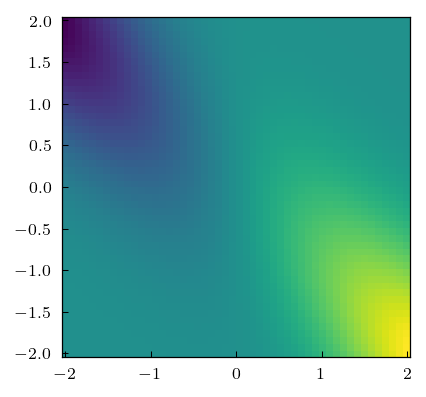

In [104]:
grad_q = jacfwd(q)
grad = grad_q(e, xy, z0)
plt.pcolor(X, Y, grad.reshape((50, 50, 2))[..., 0].T)

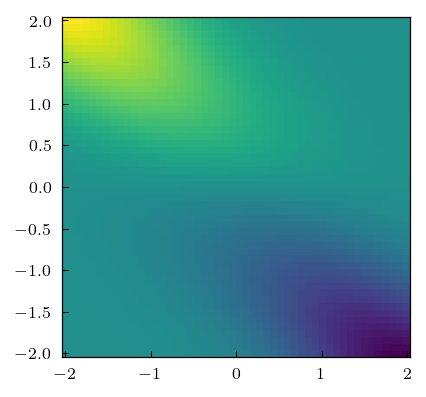

In [105]:
plt.pcolor(X, Y, grad.reshape((50, 50, 2))[..., 1].T)

## Double well potential test

In [46]:
from extq.examples import doublewell, baoab

In [53]:
import numba as nb

In [179]:
def potential(x):
    return 2.5 * (x[0] ** 2 - 1.0) ** 2 + 5.0 * x[1] ** 2

doublewell_force = jit(grad(potential))

def step2d(force, kT, dt, x, y, rx, ry):
    bd = np.sqrt(0.5 * kT * dt)
    fx, fy = -1 * force(jnp.array([x, y]))
    new_rx = np.random.normal()
    new_ry = np.random.normal()
    new_x = x + dt * fx + bd * (rx + new_rx)
    new_y = y + dt * fy + bd * (ry + new_ry)
    return new_x, new_y, new_rx, new_ry

def run_traj(traj, x, y, rx, ry, kT=0.5915, dt=0.005):
    for i in range(len(traj)):
        x, y, rx, ry = step2d(doublewell_force, kT, dt, x, y, rx, ry)
        traj[i, 0] = x
        traj[i, 1] = y
    return traj

def double_well_trajs(n_traj, n_frame, kT=0.5915, dt=0.005):
    result = np.empty((n_traj, n_frame, 2))
    for i in range(n_traj):
        while True:
            x0 = np.random.normal()
            y0 = np.random.normal()
            if potential([x0, y0]) < 3.0:
                break
        rx0 = np.random.normal()
        ry0 = np.random.normal()
        run_traj(result[i], x0, y0, rx0, ry0, kT=kT, dt=dt)
    return result

In [180]:
doublewell_force(np.ones(2))

DeviceArray([ 0., 10.], dtype=float64)

In [181]:
trajs = double_well_trajs(100, 1000)

In [188]:
trajs.shape

(100, 1000, 2)

In [203]:
lag = 500
sigma = 1
n_feat = 2
vec = np.random.random(size=2)
# e0 = vec / np.linalg.norm(vec)
e0 = np.array([1, 0])
z0 = np.mean(trajs, axis=(0,1))

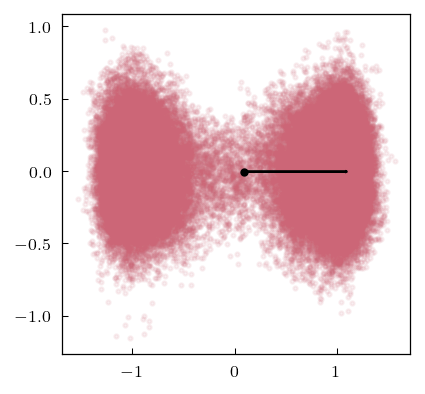

In [204]:
plt.scatter(*np.concatenate(trajs).T, alpha=0.1)
plt.arrow(*z0, *e0)
plt.plot(*z0, '.', ms=6, color='black')

In [207]:
q_dw = q(e0, trajs, z0)

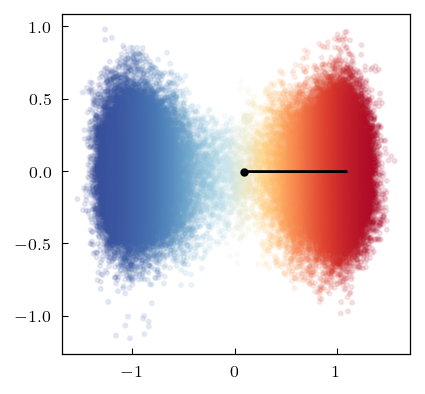

In [210]:
plt.scatter(*np.concatenate(trajs).T, c=np.concatenate(q_dw), cmap='diverging', alpha=0.1)
plt.arrow(*z0, *e0)
plt.plot(*z0, '.', ms=6, color='black')

In [224]:
C = 0
lag = 10
for z in trajs[:2]:
    q_0 = q(e0, z[:-lag], z0, sigma=sigma)
    q_tau = q(e0, z[lag:], z0, sigma=sigma)
    print(q_0.shape, q_tau.shape)
    C -= jnp.mean(q_0 * q_tau)
    C += jnp.mean(q_0**2)
print(C)

(990,) (990,)
(990,) (990,)
0.0028464961792390962


In [225]:
C = 0
lag = 10
for z in trajs[:2]:
    q_0 = q(e0, z[:-lag], z0, sigma=sigma)
    q_tau = q(e0, z[lag:], z0, sigma=sigma)
    C += 0.5 * jnp.mean((q_tau - q_0)**2)

In [226]:
C

DeviceArray(0.00306754, dtype=float64)

In [230]:
corr_all = []
lags = (1, 2, 5, 10, 20, 50, 100, 200, 500)
for t in lags:
    corr_all.append(corr_q(e0, trajs, z0, lag=t))

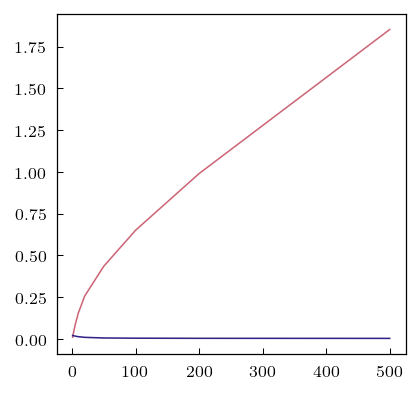

In [233]:
plt.plot(lags, corr_all)
plt.plot(lags, np.gradient(corr_all, lags))

In [296]:
lag = 100
sigma = 1
n_feat = 2
vec = np.random.normal(size=2)
e0 = vec / np.linalg.norm(vec)
z0 = np.mean(trajs, axis=(0,1))

In [300]:
def corr_q(e, z_traj, z0, lag=500, sigma=1):
    C = 0
    for z in z_traj:
        q_0 = q(e, z[:-lag], z0, sigma=sigma)
        q_tau = q(e, z[lag:], z0, sigma=sigma)
        # C += jnp.mean(q_0 * q_tau)
        # C -= jnp.mean(q_0**2)
        C += jnp.mean((q_tau - q_0)**2)
    return -0.5 * C

In [301]:
grad_cq = jacrev(corr_q)
hess = jacfwd(grad_cq)

In [288]:
g = grad_cq(e0, trajs, z0, lag=lag, sigma=sigma)
h = hess(e0, trajs, z0, lag=lag, sigma=sigma)
print(g)
print(h)

[-0.26694596  0.49823717]
[[-1.09864116  1.18694758]
 [ 1.18694758  1.11543942]]


In [302]:
jit_grad = jit(grad_cq, static_argnames=('lag', 'sigma'))
jit_hess = jit(hess, static_argnames=('lag', 'sigma'))

In [290]:
jit_grad(e0, trajs, z0, lag=lag, sigma=sigma)

DeviceArray([-0.26694596,  0.49823717], dtype=float64)

In [303]:
solve_ans = scipy.optimize.minimize(
    corr_q,
    e0,
    args=(trajs, z0), 
    method='trust-constr', 
    jac=jit_grad, 
    hess=jit_hess, 
    constraints=constraint, 
    options={'verbose': 2})

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | -1.7764e+00 | 1.00e+00 | 2.61e-01 | 2.22e-16 |
|   2   |   3   |   1   | -1.7764e+00 | 2.23e-01 | 2.61e-01 | 2.22e-16 |
|   3   |   4   |   2   | -1.8657e+00 | 4.47e-01 | 1.64e-01 | 4.99e-02 |
|   4   |   5   |   3   | -1.9100e+00 | 4.47e-01 | 2.94e-02 | 8.53e-02 |
|   5   |   6   |   4   | -1.8552e+00 | 4.47e-01 | 4.28e-03 | 3.80e-03 |
|   6   |   7   |   5   | -1.8525e+00 | 4.47e-01 | 2.77e-05 | 3.47e-05 |
|   7   |   8   |   6   | -1.8525e+00 | 4.47e-01 | 1.43e-09 | 1.54e-09 |

`gtol` termination condition is satisfied.
Number of iterations: 7, function evaluations: 8, CG iterations: 6, optimality: 1.43e-09, constraint violation: 1.54e-09, execution time: 0.55 s.


In [304]:
e0

array([ 0.88300721, -0.46935943])

In [305]:
solve_ans.x

array([ 0.99966259, -0.02597532])

In [294]:
z0

array([ 0.09372548, -0.00455042])

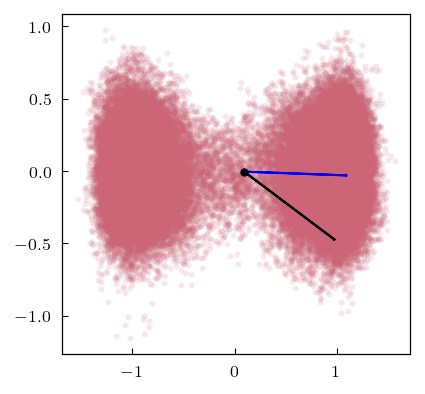

In [306]:
plt.scatter(*np.concatenate(trajs).T, alpha=0.1)
plt.arrow(*z0, *e0)
plt.arrow(*z0, *solve_ans.x, color='blue')
plt.plot(*z0, '.', ms=6, color='black')